In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

# some pandas options
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.set_option("display.expand_frame_repr", False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

# Silent payment transaction scanning

A silent payments light client needs 33 bytes for each transaction it wants to check. More specifically, each transaction with at least one unspent taproot output. Naively, this means a light client would need to download 500 MB of data per month, i.e.,

$$
33\cdot 3500\cdot 144\cdot 30 \thickapprox 500 MB
$$

This assumes on average each block has 3500 transactions and every transaction has at least one unspent taproot output. In practice, we can substantually reduce the number by taking advantage of transaction cut-through and dust filters.

## Transaction cut-through

Simply put, this means skipping transactions that are not relevant for us. In a silent payments context, this means skip downloading data for all transactions where the taproot outputs have been spent. Obviously, a UTXO that has already been spent was never a UTXO for us to begin with.

## Dust filters

Building on the idea of not doing work for things that are not relevant to us, we can also skip transactions where the only unspent taproot outputs in the transaction are dust (or close to dust) valued outputs. For silent payments scanning, I'm not interested in downloading 33 bytes of data and doing an ECDH calculation only to find out the UTXO in the transaction is not economical to spend at current feerates.

An interesting property here is the client can always retrieve these dust outputs by initiating an ad hoc scan for an older timeframe without the dust filter. A use case here would be a client that only wants to download higher value UTXOs on the go, but may want to scan without a dust limit for all UTXOs once connected to WIFI where bandwidth is not a concern.


# Simulation

We can simulate scanning by creating a data set of transactions where for each transaction we have the block height it was created and the block height where the last non-dust taproot output was spent. From this we can calculate how much data a light client would need to download if it scans every 3 blocks, once every three days, once per week, etc. It's worth mentioning that if a client is frequently scanning, it's likely they are receiving a high volume of payments and should absolutely be running their own node at that point. Given that, scanning once every three days or once per week is the behavior we would expect from a light client.

Additionally, we use a dust filter of 546 sats. This is to match the value historically used for dust, but in practice its more likely a client would use something like 1000 sats. This is because 546 was calculated with a 1sat/vbyte relay fee assumption, but current fees are higher (and expected to rise in the future). Given this, UTXOs with values between 546 and 1000 sats might already be unspendable at current feerates.

In [ ]:
%%bigquery vintage_per_taproot_output
SELECT block_timestamp, created, spent, spent - created AS vintage FROM (
SELECT block_timestamp
     , transaction_hash
     , created
     , MAX(spent) as spent 
  FROM
(
SELECT o.transaction_hash
     , o.block_timestamp
     , o.block_number as created
     , IFNULL(i.block_number, 860000) as spent
  FROM `bigquery-public-data.crypto_bitcoin.outputs` o
  LEFT JOIN `bigquery-public-data.crypto_bitcoin.inputs` i 
         ON o.transaction_hash = i.spent_transaction_hash 
        AND o.index = i.spent_output_index
      WHERE o.type = "witness_v1_taproot"
        AND o.value > 546
        AND o.block_timestamp >= "2023-01-01"
        AND o.block_timestamp <  "2024-07-01"
) GROUP BY 1,2,3)
;

## Transaction "lifespan" 2023-01 to 2024-07

Now that we know when a transaction was created and when the last non-dust UTXO was spent, we can calculate how long transactions exist with at least one non-dust UTXO in the UTXO set.

In [51]:
vintage_per_taproot_output['tx_status'] = vintage_per_taproot_output.apply(
    lambda x: 'not_spent' if x['spent'] == 860000 else 'fully_spent',
    axis=1
)

In [52]:
vintage_per_taproot_output.groupby('tx_status')['vintage'].describe()

,count,mean,std,min,25%,50%,75%,max
tx_status,,,,,,,,
fully_spent,40579389.0,1296.863899,4991.297841,0.0,0.0,1.0,150.0,81411.0
not_spent,6241837.0,38734.877003,20318.933087,9840.0,22913.0,33955.0,48727.0,90213.0


The table above shows that from 2023-01 until 2024-07, 50% of all transactions had their non-dust taproot UTXOs spent in 1 block or less and 75% of all transactions had all of their non-dust taproot UTXOs spent in 150 blocks or less.

## Scanning frequency

The following is a simulation of a silent payment light client which scans at different intervals: every 3 blocks, once a day, once a week, etc.

In [53]:
block_intervals = vintage_per_taproot_output.groupby(
    ['block_timestamp','created','spent']
)['tx_status'].count()
bi_df = block_intervals.reset_index().rename(columns={'vintage':'total'}).sort_values(by='created')

In [56]:
def sum_txs(group_range, df):
    df['block_timestamp_scan'] = df['block_timestamp'].max()
    return df.groupby(
        df['block_timestamp_scan']
    ).apply(lambda x: x[x['spent'] > group_range.right]['tx_status'].sum() * 33 * 0.000001)

In [57]:
start = min_block
end = max_block

interval = 3
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
every_10_blocks = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': '3 blocks'})

# once every 144 blocks
interval = 144
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
once_per_day = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'daily'})

# once every 3 days
interval = 144 * 3
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
every_three_days = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'three days'})

# once every week 
interval = 144 * 7
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
once_per_week = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'weekly'})

# once every month
interval = 144 * 30
scans = list(range(start, end, interval))
groups = bi_df.groupby(pd.cut(bi_df['created'], scans))
results = bi_df.groupby(
    pd.cut(bi_df['created'], scans)
).apply(lambda x: sum_txs(x.name, x)).reset_index(name='scanned_mbs')[['block_timestamp_scan', 'scanned_mbs']]
once_per_month = results.set_index('block_timestamp_scan').rename(columns={'scanned_mbs': 'monthly'})

Text(0.5, 1.0, 'Scan data downloaded (MBs per month)')

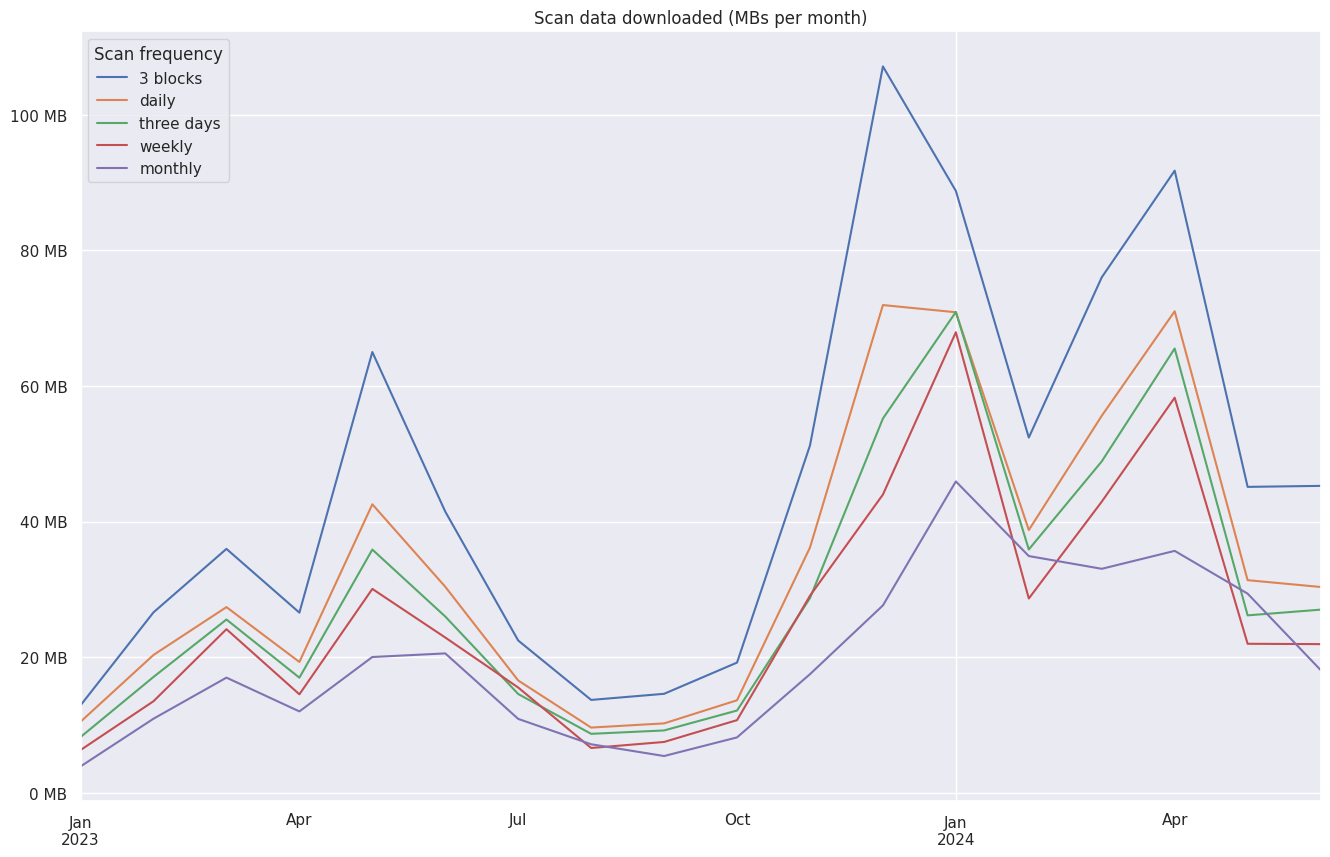

In [58]:
ax1 = every_10_blocks.groupby(pd.Grouper(freq='M')).sum().plot(figsize=(16,10))
once_per_day.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
every_three_days.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
once_per_week.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
once_per_month.groupby(pd.Grouper(freq='M')).sum().plot(ax=ax1)
ax1.legend(title='Scan frequency')

from matplotlib.ticker import FormatStrFormatter

ax1.yaxis.set_major_formatter(FormatStrFormatter('%d MB'))
ax1.xaxis.label.set_visible(False)
ax1.set_title('Scan data downloaded (MBs per month)')

<AxesSubplot:xlabel='block_timestamp_scan'>

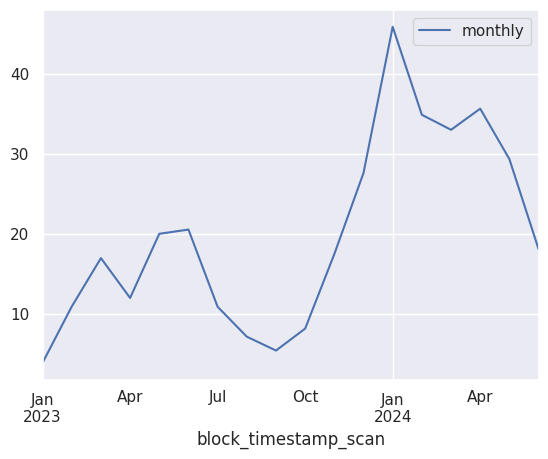

In [59]:
once_per_month.groupby(pd.Grouper(freq='M')).sum().plot()

<AxesSubplot:xlabel='block_timestamp_scan'>

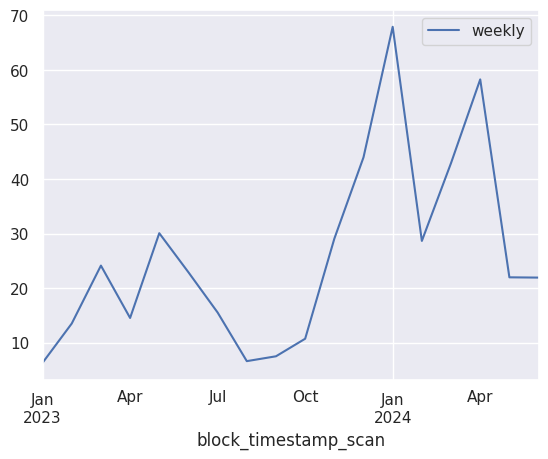

In [60]:
once_per_week.groupby(pd.Grouper(freq='M')).sum().plot()

<AxesSubplot:xlabel='block_timestamp_scan'>

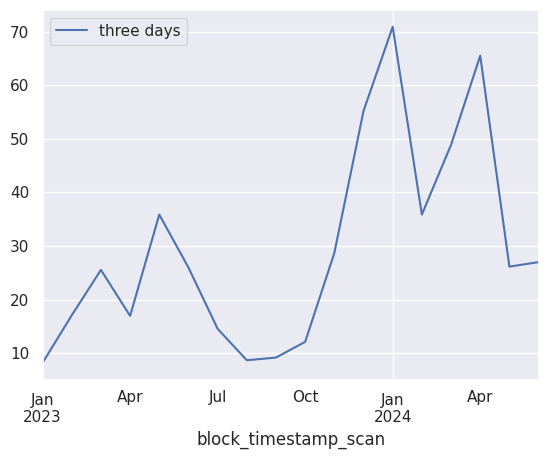

In [61]:
every_three_days.groupby(pd.Grouper(freq='M')).sum().plot()

In [62]:
every_three_days.groupby(pd.Grouper(freq='M')).sum().mean()

three days    29.579552
dtype: float64

In [63]:
once_per_month.groupby(pd.Grouper(freq='M')).sum().mean()

monthly    19.88989
dtype: float64

In [64]:
once_per_week.groupby(pd.Grouper(freq='M')).sum().mean()

weekly    25.907611
dtype: float64

In [65]:
every_10_blocks.groupby(pd.Grouper(freq='M')).sum().mean()

3 blocks    46.446624
dtype: float64